# Transformer Warmup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import time
import copy
import nltk
from nltk.translate.bleu_score import sentence_bleu
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Part 1: Implementing a Simple Transformer Model

In [2]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding for the transformer model.
    Adds information about the position of tokens in the sequence.
    """
    def __init__(self, d_model, max_seq_length=100, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Apply sin to even indices and cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension and register as buffer (not a parameter)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape [batch_size, seq_length, d_model]
        Returns:
            Output tensor with positional encoding added
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention layer as described in the 'Attention is All You Need' paper.
    Allows the model to jointly attend to information from different positions.
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension of each head's key/query/value
        
        # Linear projections for Q, K, V, and output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def split_heads(self, x):
        """
        Split the last dimension into (num_heads, d_k)
        and transpose to (batch_size, num_heads, seq_length, d_k)
        """
        batch_size, seq_length = x.size(0), x.size(1)
        x = x.view(batch_size, seq_length, self.num_heads, self.d_k)
        return x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_length, d_k)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Compute scaled dot-product attention
        
        Args:
            Q: Query matrix of shape [batch_size, num_heads, seq_length, d_k]
            K: Key matrix of shape [batch_size, num_heads, seq_length, d_k]
            V: Value matrix of shape [batch_size, num_heads, seq_length, d_k]
            mask: Optional mask tensor of shape [batch_size, 1, 1/seq_length, seq_length]
        
        Returns:
            Output tensor after attention and attention weights
        """
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention weights to values
        output = torch.matmul(attention_weights, V)
        
        return output, attention_weights
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear projections and split heads
        Q = self.split_heads(self.W_q(query))
        K = self.split_heads(self.W_k(key))
        V = self.split_heads(self.W_v(value))
        
        # Apply scaled dot-product attention
        attn_output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Transpose and concat heads
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        attn_output = attn_output.view(batch_size, -1, self.d_model)
        
        # Final linear projection
        output = self.W_o(attn_output)
        
        return output, attn_weights

class PositionwiseFeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network of the Transformer model.
    Consists of two linear transformations with a ReLU activation in between.
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape [batch_size, seq_length, d_model]
        Returns:
            Output tensor of shape [batch_size, seq_length, d_model]
        """
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class EncoderLayer(nn.Module):
    """
    Single encoder layer of the transformer model.
    Consists of multi-head attention and position-wise feed-forward networks.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input tensor of shape [batch_size, seq_length, d_model]
            mask: Optional mask for attention
        Returns:
            Output tensor of shape [batch_size, seq_length, d_model]
        """
        # Multi-head attention with residual connection
        attn_output, _ = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward network with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

class DecoderLayer(nn.Module):
    """
    Single decoder layer of the transformer model.
    Consists of two multi-head attention layers and a position-wise feed-forward network.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        """
        Args:
            x: Input tensor of shape [batch_size, seq_length, d_model]
            encoder_output: Output from encoder of shape [batch_size, src_seq_length, d_model]
            src_mask: Mask for source sequence
            tgt_mask: Mask for target sequence (usually to prevent seeing future tokens)
        Returns:
            Output tensor of shape [batch_size, seq_length, d_model]
        """
        # Self-attention with residual connection
        attn_output, _ = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Cross-attention with residual connection
        attn_output, _ = self.cross_attention(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        
        # Feed-forward network with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        
        return x

class Encoder(nn.Module):
    """
    Encoder stack of the transformer model.
    Consists of multiple encoder layers.
    """
    def __init__(self, input_dim, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input tensor of shape [batch_size, seq_length]
            mask: Optional mask for attention
        Returns:
            Output tensor of shape [batch_size, seq_length, d_model]
        """
        # Apply embedding and positional encoding
        x = self.embedding(x)
        x = self.positional_encoding(x)
        
        # Pass through each encoder layer
        for layer in self.layers:
            x = layer(x, mask)
            
        return x

class Decoder(nn.Module):
    """
    Decoder stack of the transformer model.
    Consists of multiple decoder layers.
    """
    def __init__(self, output_dim, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super(Decoder, self).__init__()
        
        self.embedding = nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(d_model, output_dim)
        
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        """
        Args:
            x: Input tensor of shape [batch_size, seq_length]
            encoder_output: Output from encoder of shape [batch_size, src_seq_length, d_model]
            src_mask: Mask for source sequence
            tgt_mask: Mask for target sequence (usually to prevent seeing future tokens)
        Returns:
            Output tensor of shape [batch_size, seq_length, output_dim]
        """
        # Apply embedding and positional encoding
        x = self.embedding(x)
        x = self.positional_encoding(x)
        
        # Pass through each decoder layer
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
            
        # Final linear projection
        x = self.fc_out(x)
        
        return x

class Transformer(nn.Module):
    """
    Complete Transformer model.
    Consists of an encoder stack and a decoder stack.
    """
    def __init__(self, input_dim, output_dim, d_model, num_heads, d_ff, 
                 num_encoder_layers, num_decoder_layers, dropout=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(input_dim, d_model, num_heads, d_ff, 
                              num_encoder_layers, dropout)
        
        self.decoder = Decoder(output_dim, d_model, num_heads, d_ff, 
                              num_decoder_layers, dropout)
        
        self.pad_idx = 0  # Assume 0 is the padding index
        
    def make_src_mask(self, src):
        """
        Create a mask for the source sequence to hide padding tokens.
        
        Args:
            src: Source sequence tensor of shape [batch_size, src_seq_length]
        Returns:
            src_mask: Mask tensor of shape [batch_size, 1, 1, src_seq_length]
        """
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_tgt_mask(self, tgt):
        """
        Create a mask for the target sequence to hide padding tokens
        and prevent seeing future tokens.
        
        Args:
            tgt: Target sequence tensor of shape [batch_size, tgt_seq_length]
        Returns:
            tgt_mask: Mask tensor of shape [batch_size, 1, tgt_seq_length, tgt_seq_length]
        """
        tgt_pad_mask = (tgt != self.pad_idx).unsqueeze(1).unsqueeze(3)
        
        tgt_len = tgt.shape[1]
        tgt_sub_mask = torch.tril(torch.ones((tgt_len, tgt_len))).to(device)
        tgt_sub_mask = tgt_sub_mask.bool()
        
        tgt_mask = tgt_pad_mask & tgt_sub_mask
        return tgt_mask
    
    def forward(self, src, tgt):
        """
        Forward pass through the Transformer model.
        
        Args:
            src: Source sequence tensor of shape [batch_size, src_seq_length]
            tgt: Target sequence tensor of shape [batch_size, tgt_seq_length]
        Returns:
            output_probs: Output probabilities tensor of shape 
                         [batch_size, tgt_seq_length, output_dim]
        """
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        
        # Pass through encoder
        encoder_output = self.encoder(src, src_mask)
        
        # Pass through decoder
        output = self.decoder(tgt, encoder_output, src_mask, tgt_mask)
        
        return output

### Part 2: Simple NLP Use Case - English to German Translation

Source vocabulary size: 50
Target vocabulary size: 51
Sample source vocab items: [('<pad>', 0), ('<sos>', 1), ('<eos>', 2), ('<unk>', 3), ('hello', 4), ('good', 5), ('morning', 6), ('thank', 7), ('you', 8), ('how', 9)]
Sample target vocab items: [('<pad>', 0), ('<sos>', 1), ('<eos>', 2), ('<unk>', 3), ('hallo', 4), ('guten', 5), ('morgen', 6), ('danke', 7), ('wie', 8), ('geht', 9)]
Initializing the Transformer model...
Total number of parameters: 1408051
Training the model...
Epoch: 01 | Time: 0.0m 0.19s
	Train Loss: 3.689 | Val. Loss: 3.300
Epoch: 02 | Time: 0.0m 0.21s
	Train Loss: 3.121 | Val. Loss: 3.352
Epoch: 03 | Time: 0.0m 0.15s
	Train Loss: 2.806 | Val. Loss: 3.368
Epoch: 04 | Time: 0.0m 0.15s
	Train Loss: 2.380 | Val. Loss: 3.356
Epoch: 05 | Time: 0.0m 0.14s
	Train Loss: 2.059 | Val. Loss: 3.283
Epoch: 06 | Time: 0.0m 0.17s
	Train Loss: 1.722 | Val. Loss: 3.133
Epoch: 07 | Time: 0.0m 0.17s
	Train Loss: 1.391 | Val. Loss: 3.106
Epoch: 08 | Time: 0.0m 0.22s
	Train Loss: 1.184 | 

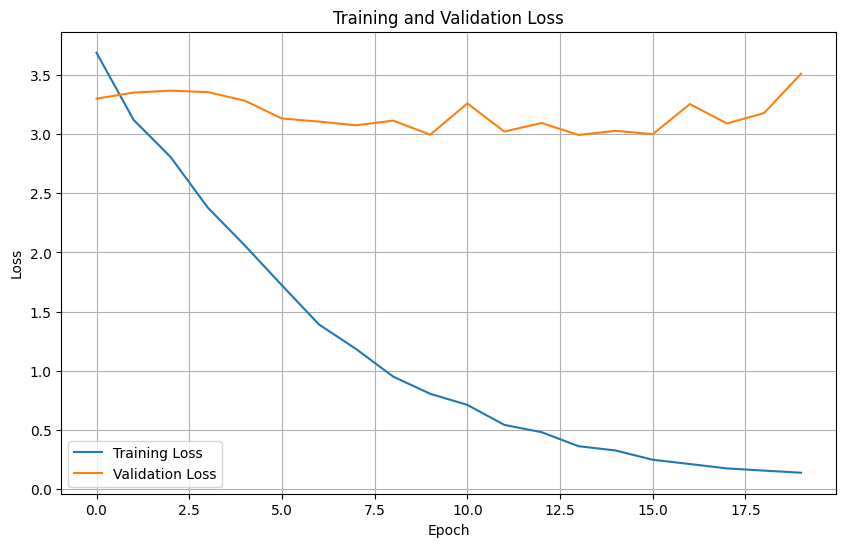


Testing the model with example sentences:
Source: hello
Predicted: wie geht es dir
Ground truth: hallo

Source: thank you
Predicted: danke
Ground truth: danke

Source: how are you
Predicted: wie geht es dir
Ground truth: wie geht es dir

Source: i am learning german
Predicted: ich bin ein student
Ground truth: ich lerne deutsch



/tmp/ipykernel_11471/2946757025.py:298: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-transformer-model.pt'))


In [3]:
# Small dataset of English-German sentence pairs
en_de_pairs = [
    ("hello", "hallo"),
    ("good morning", "guten morgen"),
    ("thank you", "danke"),
    ("how are you", "wie geht es dir"),
    ("my name is", "mein name ist"),
    ("i love programming", "ich liebe programmieren"),
    ("what is your name", "wie heißt du"),
    ("i am a student", "ich bin ein student"),
    ("i live in berlin", "ich wohne in berlin"),
    ("where do you live", "wo wohnst du"),
    ("the weather is nice", "das wetter ist schön"),
    ("i like to read books", "ich lese gerne bücher"),
    ("i speak english", "ich spreche englisch"),
    ("do you speak german", "sprichst du deutsch"),
    ("i work as a programmer", "ich arbeite als programmierer"),
    ("i am learning german", "ich lerne deutsch"),
    ("please help me", "bitte hilf mir"),
    ("what time is it", "wie spät ist es"),
    ("i have a question", "ich habe eine frage"),
    ("i don't understand", "ich verstehe nicht")
]

# Split into training and validation sets
train_pairs, val_pairs = train_test_split(en_de_pairs, test_size=0.2, random_state=42)

# Build vocabulary
def build_vocab(sentence_pairs, language_idx):
    """Build vocabulary from sentence pairs"""
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    idx = 4  # Start index after special tokens
    
    for pair in sentence_pairs:
        for word in pair[language_idx].split():
            if word not in vocab:
                vocab[word] = idx
                idx += 1
                
    return vocab, idx

src_vocab, src_vocab_size = build_vocab(en_de_pairs, 0)  # English
tgt_vocab, tgt_vocab_size = build_vocab(en_de_pairs, 1)  # German

# Create reverse vocabulary for translation
idx_to_src = {v: k for k, v in src_vocab.items()}
idx_to_tgt = {v: k for k, v in tgt_vocab.items()}

# Print vocabulary information
print(f"Source vocabulary size: {src_vocab_size}")
print(f"Target vocabulary size: {tgt_vocab_size}")
print(f"Sample source vocab items: {list(src_vocab.items())[:10]}")
print(f"Sample target vocab items: {list(tgt_vocab.items())[:10]}")

# 2.2 Create Dataset and Dataloader
class TranslationDataset(Dataset):
    """Dataset for machine translation task"""
    def __init__(self, pairs, src_vocab, tgt_vocab, max_len=10):
        self.pairs = pairs
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        src_text, tgt_text = self.pairs[idx]
        
        # Convert source sentence to indices
        src_tokens = src_text.split()
        src_indices = [self.src_vocab.get(token, self.src_vocab['<unk>']) for token in src_tokens]
        src_indices = [self.src_vocab['<sos>']] + src_indices + [self.src_vocab['<eos>']]
        
        # Pad source sentence
        src_padding = [self.src_vocab['<pad>']] * (self.max_len - len(src_indices))
        src_indices = src_indices + src_padding if len(src_indices) < self.max_len else src_indices[:self.max_len]
        
        # Convert target sentence to indices
        tgt_tokens = tgt_text.split()
        tgt_indices = [self.tgt_vocab.get(token, self.tgt_vocab['<unk>']) for token in tgt_tokens]
        tgt_indices = [self.tgt_vocab['<sos>']] + tgt_indices + [self.tgt_vocab['<eos>']]
        
        # Pad target sentence
        tgt_padding = [self.tgt_vocab['<pad>']] * (self.max_len - len(tgt_indices))
        tgt_indices = tgt_indices + tgt_padding if len(tgt_indices) < self.max_len else tgt_indices[:self.max_len]
        
        # For training, we need:
        # 1. Source sequence
        # 2. Target sequence (input to decoder)
        # 3. Target sequence shifted by one (expected output)
        
        src_tensor = torch.tensor(src_indices, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt_indices, dtype=torch.long)
        
        return src_tensor, tgt_tensor

# Create datasets and dataloaders
train_dataset = TranslationDataset(train_pairs, src_vocab, tgt_vocab)
val_dataset = TranslationDataset(val_pairs, src_vocab, tgt_vocab)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 2.3 Initialize and Train the Model
def train_epoch(model, train_loader, optimizer, criterion, clip=1.0):
    """Train the model for one epoch"""
    model.train()
    epoch_loss = 0
    
    for i, (src, tgt) in enumerate(train_loader):
        src = src.to(device)
        tgt = tgt.to(device)
        
        # Remove the last element of target for input to decoder
        tgt_input = tgt[:, :-1]
        
        # Remove the first element of target for output comparison
        tgt_output = tgt[:, 1:]
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src, tgt_input)
        
        # Reshape output and target for cross-entropy loss
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        tgt_output = tgt_output.contiguous().view(-1)
        
        # Calculate loss
        loss = criterion(output, tgt_output)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Update parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_loader)

def evaluate(model, val_loader, criterion):
    """Evaluate the model on validation data"""
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for i, (src, tgt) in enumerate(val_loader):
            src = src.to(device)
            tgt = tgt.to(device)
            
            # Remove the last element of target for input to decoder
            tgt_input = tgt[:, :-1]
            
            # Remove the first element of target for output comparison
            tgt_output = tgt[:, 1:]
            
            # Forward pass
            output = model(src, tgt_input)
            
            # Reshape output and target for cross-entropy loss
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            tgt_output = tgt_output.contiguous().view(-1)
            
            # Calculate loss
            loss = criterion(output, tgt_output)
            
            val_loss += loss.item()
            
    return val_loss / len(val_loader)

def translate_sentence(model, sentence, src_vocab, tgt_vocab, idx_to_tgt, max_len=10):
    """Translate an English sentence to German"""
    model.eval()
    
    # Tokenize sentence
    tokens = sentence.split()
    
    # Convert tokens to indices
    src_indices = [src_vocab.get(token, src_vocab['<unk>']) for token in tokens]
    src_indices = [src_vocab['<sos>']] + src_indices + [src_vocab['<eos>']]
    
    # Pad source sentence
    src_padding = [src_vocab['<pad>']] * (max_len - len(src_indices))
    src_indices = src_indices + src_padding if len(src_indices) < max_len else src_indices[:max_len]
    
    # Convert to tensor
    src_tensor = torch.tensor(src_indices).unsqueeze(0).to(device)
    
    # Initialize target tensor with SOS token
    tgt_indices = [tgt_vocab['<sos>']]
    
    with torch.no_grad():
        # Get encoder output
        encoder_output = model.encoder(src_tensor, model.make_src_mask(src_tensor))
        
        # Generate output sequence
        for i in range(max_len - 1):
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            tgt_mask = model.make_tgt_mask(tgt_tensor)
            
            # Forward pass through decoder
            output = model.decoder(tgt_tensor, encoder_output, 
                                   model.make_src_mask(src_tensor), tgt_mask)
            
            # Get next token prediction
            pred_token = output.argmax(2)[:, -1].item()
            
            # Add prediction to sequence
            tgt_indices.append(pred_token)
            
            # Stop if EOS token is predicted
            if pred_token == tgt_vocab['<eos>']:
                break
    
    # Convert indices to tokens
    tgt_tokens = [idx_to_tgt[idx] for idx in tgt_indices if idx not in [tgt_vocab['<pad>'], tgt_vocab['<sos>'], tgt_vocab['<eos>']]]
    
    return ' '.join(tgt_tokens)

# Initialize the Transformer model
print("Initializing the Transformer model...")
input_dim = src_vocab_size
output_dim = tgt_vocab_size
d_model = 128
num_heads = 4
d_ff = 512
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.1

model = Transformer(input_dim, output_dim, d_model, num_heads, d_ff, 
                   num_encoder_layers, num_decoder_layers, dropout).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Define optimizer and loss function
learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])

# Train the model
print("Training the model...")
n_epochs = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    start_time = time.time()
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    
    # Check if this is the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best-transformer-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {val_loss:.3f}')
    
    # Early stopping check (simple version)
    if epoch > 10 and val_losses[-1] > val_losses[-2] > val_losses[-3]:
        print("Early stopping triggered")
        break

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2.4 Test the model with some examples
print("\nTesting the model with example sentences:")

# Load the best model
model.load_state_dict(torch.load('best-transformer-model.pt'))

test_sentences = [
    "hello",
    "thank you",
    "how are you",
    "i am learning german"
]

for sentence in test_sentences:
    translation = translate_sentence(model, sentence, src_vocab, tgt_vocab, idx_to_tgt)
    print(f'Source: {sentence}')
    print(f'Predicted: {translation}')
    
    # Find ground truth if available
    for pair in en_de_pairs:
        if pair[0] == sentence:
            print(f'Ground truth: {pair[1]}')
            break
    print()




# Questions to consider:
1. How does the Transformer architecture differ from RNNs or LSTMs?
2. What is the role of positional encoding in Transformer models?
3. How does multi-head attention allow the model to focus on different parts of the input?
4. What is the purpose of the mask in the decoder's self-attention?
5. How would you modify this model for different NLP tasks like text classification?
6. What are the limitations of this simple implementation compared to state-of-the-art models?